In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, auc, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from data_repository import DataRepository

# Import data

In [3]:
data_repo = DataRepository("../.env")
#Clean data
train_ampls, y_train, validation_ampls, y_validation, test_ampls, y_test = data_repo.load_fft_data(clean_data=False)

In [4]:
print(f"Train dataset: X: {train_ampls.shape}, y: {y_train.shape}")
print(f"Validation dataset: X: {validation_ampls.shape}, y: {y_validation.shape}")
print(f"Test dataset: X: {test_ampls.shape}, y: {y_test.shape}")

Train dataset: X: (8649, 4501), y: (8649,)
Validation dataset: X: (1191, 4501), y: (1191,)
Test dataset: X: (2160, 4501), y: (2160,)


__Label encoder__

In [5]:
# Chuyển đổi danh sách labels thành mã số
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)
y_test = label_encoder.transform(y_test)

In [6]:
print(list(label_encoder.classes_))
print(label_encoder.transform(list(label_encoder.classes_)))

['error', 'normal', 'overcurrent', 'overheating', 'zero']
[0 1 2 3 4]


# Feature selection

## Finding top 50 highest amplitudes

In [7]:
def find_top_k_indices(amplitudes, k):
    # Get the indices of the top 50 elements
    top_k_indices = np.argsort(amplitudes)[-k:][::-1]
    highest_ampls = amplitudes[top_k_indices]
    return highest_ampls

def get_x_by_top_ampls(k, ampls):
    X = []
    for ampl in ampls:
        X.append(find_top_k_indices(amplitudes=ampl, k=k))
    return np.array(X)

__Choosing only the dc feature__

In [8]:
X_train_SVM = get_x_by_top_ampls(k=1, ampls=train_ampls)
X_validation_SVM = get_x_by_top_ampls(k=1, ampls=validation_ampls)
X_test_SVM = get_x_by_top_ampls(k=1, ampls=test_ampls)

X_train_RF = get_x_by_top_ampls(k=1, ampls=train_ampls)
X_validation_RF = get_x_by_top_ampls(k=1, ampls=validation_ampls)
X_test_RF = get_x_by_top_ampls(k=1, ampls=test_ampls)

X_train_XgBoost = get_x_by_top_ampls(k=1, ampls=train_ampls)
X_validation_XgBoost = get_x_by_top_ampls(k=1, ampls=validation_ampls)
X_test_XgBoost = get_x_by_top_ampls(k=1, ampls=test_ampls)

In [9]:
print(X_train_SVM.shape, X_validation_SVM.shape, X_test_SVM.shape)
print(X_train_RF.shape, X_validation_RF.shape, X_test_RF.shape)
print(X_train_XgBoost.shape, X_validation_XgBoost.shape, X_test_XgBoost.shape)

(8649, 1) (1191, 1) (2160, 1)
(8649, 1) (1191, 1) (2160, 1)
(8649, 1) (1191, 1) (2160, 1)


In [10]:
def evaluate_and_print_results(y_pred, y_pred_proba, y_test, label_encoder: LabelEncoder):
    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    #conf_matrix to return
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Tính toán F1-Score
    f1_macro = f1_score(y_test, y_pred, average='macro')
    #Precision and recall
    precision = precision_score(y_test, y_pred, average='macro')  
    recall = recall_score(y_test, y_pred, average='macro')
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    auc_values = []
    for i in range(n_classes):
        # Create binary labels for each class
        y_test_class = np.where(y_test == i, 1, 0)
        auc = roc_auc_score(y_test_class, y_pred_proba[:, i])
        auc_values.append(auc)
    # Tính trung bình AUC (macro-average)
    macro_avg_auc = np.mean(auc_values)  # Avoid division by zero if auc_values is empty
    #Revert transform
    y_test = label_encoder.inverse_transform(y_test)
    y_pred = label_encoder.inverse_transform(y_pred)
    # Print results
    print(classification_report(y_test, y_pred))
    print()
    print("Custom reports")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score (Macro): {f1_macro}")
    print(f"Macro-average AUC (SVM): {macro_avg_auc}")
    return conf_matrix

def plot_auc_curve(y_pred_proba, y_test, label_encoder: LabelEncoder):
    sns.set(font_scale=1.5)
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 8))
    for i in range(n_classes):
        class_name = label_encoder.inverse_transform([i])[0]
        y_test_class = np.where(y_test == i, 1, 0)
        fpr, tpr, _ = roc_curve(y_test_class, y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
def plot_conf_matrix(conf_matrix):
    sns.set(font_scale=2)
    # Define the class labels
    class_labels = ['error', 'normal', 'overcurrent', 'overheating', 'zero']
    # Create a dataframe from the confusion matrix
    df_cm = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    # Set the plot size
    plt.figure(figsize=(10, 7))
    # Plot the heatmap
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 25})
    # Set plot title and labels
    plt.xlabel('Predicted label', labelpad=15)
    plt.ylabel('True label', labelpad=15)
    plt.show()

# Model training

## SVM

### Xây dựng mô hình

In [10]:
from sklearn.svm import SVC
svm_fft = SVC(kernel='rbf', random_state=42, probability=True)
svm_fft.fit(X_train_SVM, y_train)

SVC(probability=True, random_state=42)

In [11]:
svm_y_pred_val = svm_fft.predict(X_validation_SVM)
svm_y_pred_proba_val = svm_fft.predict_proba(X_validation_SVM)

              precision    recall  f1-score   support

       error       0.83      0.83      0.83       237
      normal       0.93      0.90      0.92       247
 overcurrent       0.98      1.00      0.99       237
 overheating       0.78      0.89      0.83       223
        zero       0.98      0.86      0.92       247

    accuracy                           0.90      1191
   macro avg       0.90      0.90      0.90      1191
weighted avg       0.90      0.90      0.90      1191


Custom reports
Precision: 0.8996967891958005
Recall: 0.8969126174516902
Accuracy: 0.8967254408060453
F1-Score (Macro): 0.8966896517386147
Macro-average AUC (SVM): 0.9923173256667862


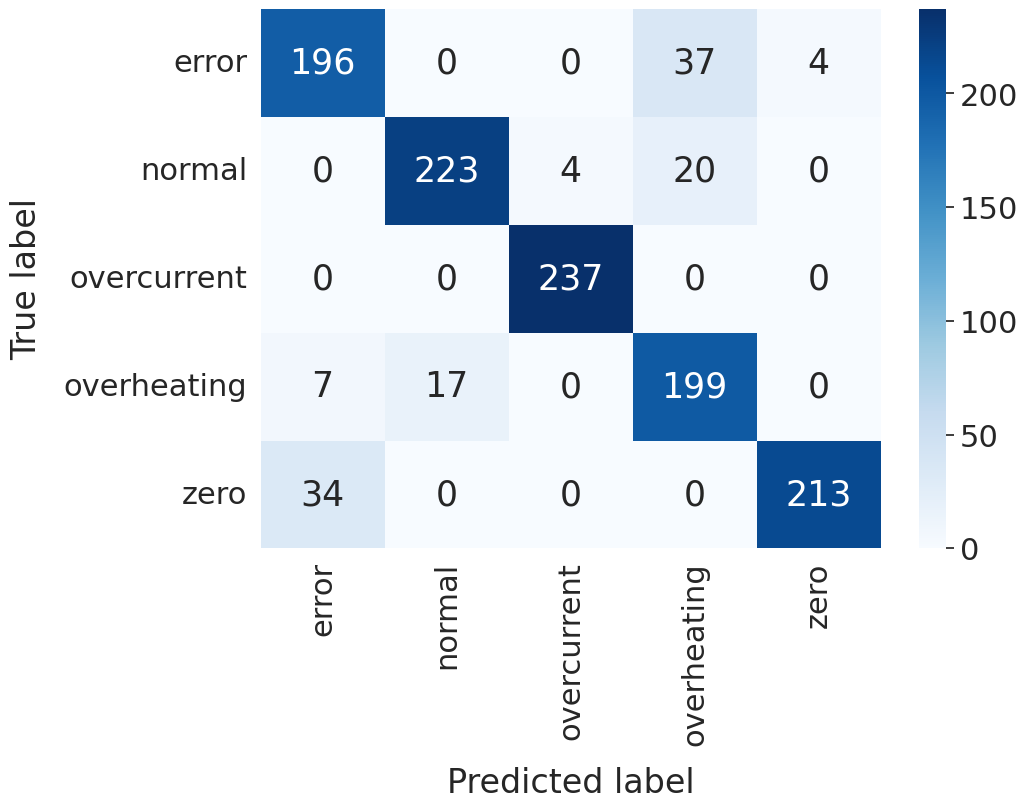

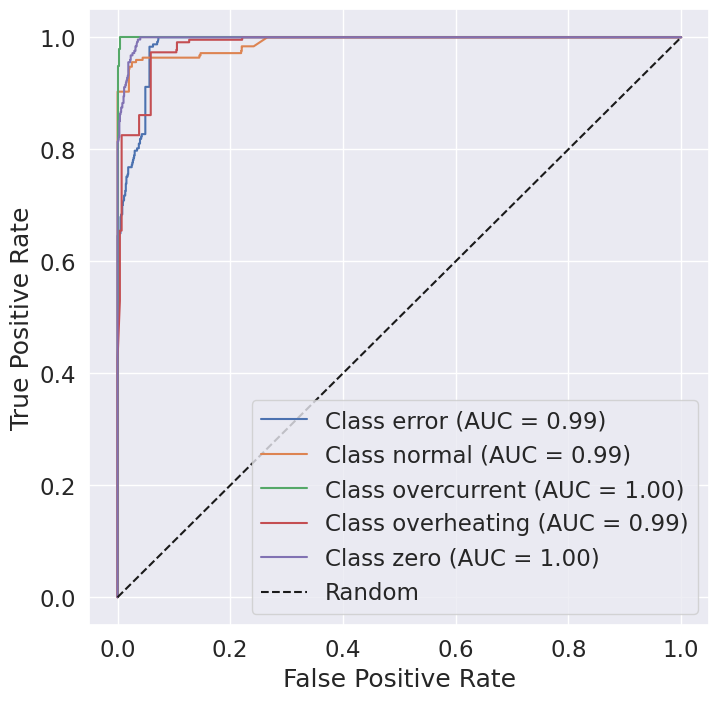

In [12]:
svm_conf_val = evaluate_and_print_results(y_pred=svm_y_pred_val, y_pred_proba=svm_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder) 
plot_conf_matrix(svm_conf_val)
plot_auc_curve(y_test=y_validation, y_pred_proba=svm_y_pred_proba_val, label_encoder=label_encoder)

In [13]:
svm_y_pred = svm_fft.predict(X_test_SVM)
svm_y_pred_proba = svm_fft.predict_proba(X_test_SVM)

              precision    recall  f1-score   support

       error       0.85      0.85      0.85       445
      normal       0.92      0.93      0.93       419
 overcurrent       0.98      1.00      0.99       454
 overheating       0.81      0.89      0.85       411
        zero       0.99      0.87      0.93       431

    accuracy                           0.91      2160
   macro avg       0.91      0.91      0.91      2160
weighted avg       0.91      0.91      0.91      2160


Custom reports
Precision: 0.9123216830944187
Recall: 0.9095480727279899
Accuracy: 0.9101851851851852
F1-Score (Macro): 0.9098443588431671
Macro-average AUC (SVM): 0.9933100795606367


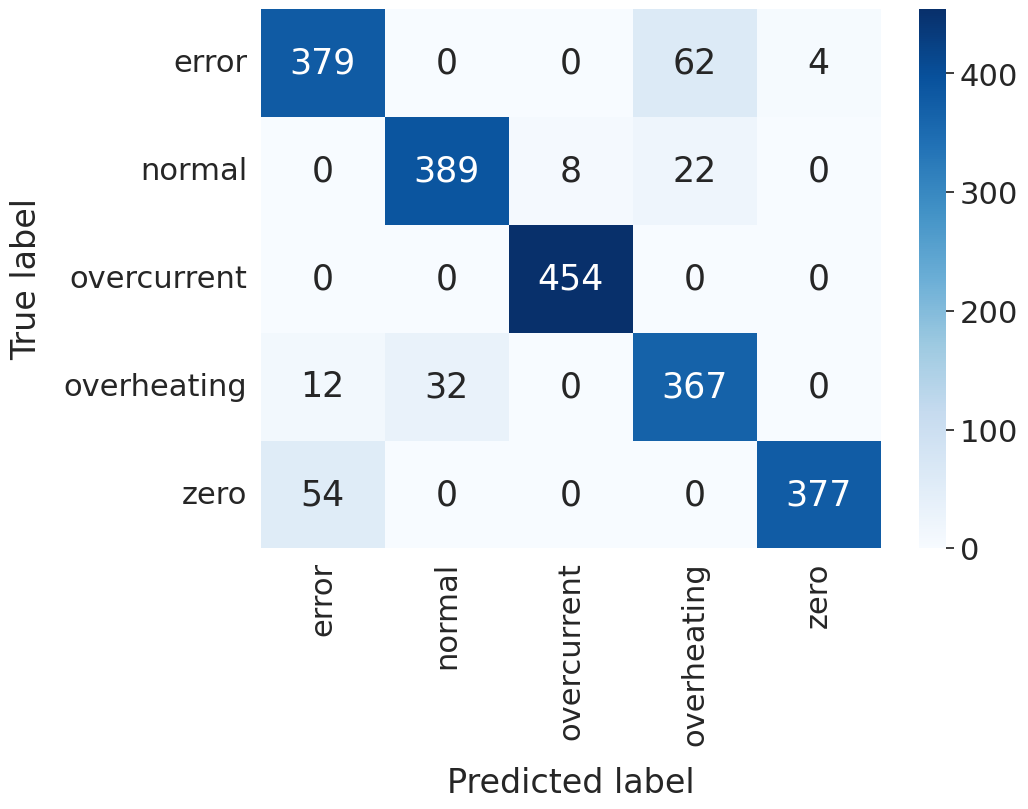

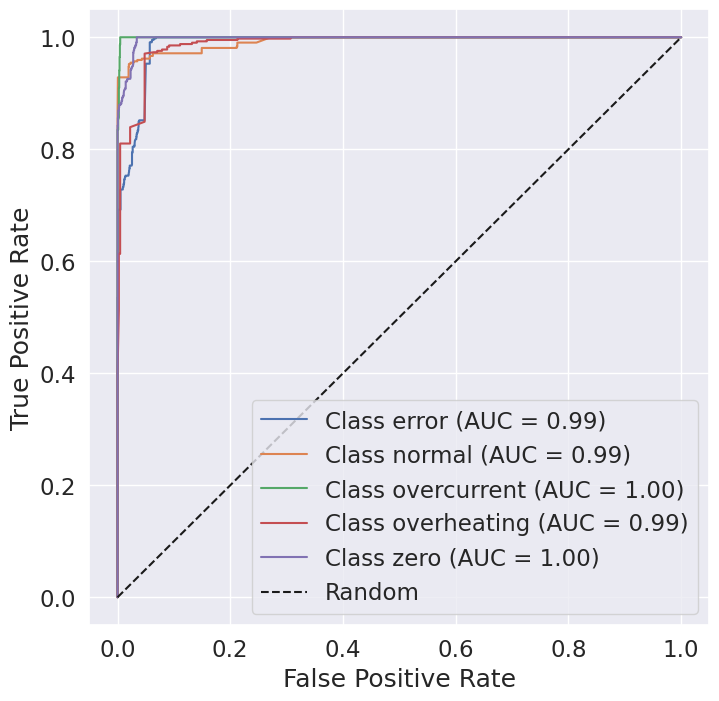

In [14]:
svm_conf = evaluate_and_print_results(y_pred=svm_y_pred, y_pred_proba=svm_y_pred_proba, y_test=y_test, label_encoder=label_encoder) 
plot_conf_matrix(svm_conf)
plot_auc_curve(y_test=y_test, y_pred_proba=svm_y_pred_proba, label_encoder=label_encoder)

## Random Forest

### Xây dựng mô hình

In [11]:
# Tạo mô hình RF
import time
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
rf_fft = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rf_fft.fit(X_train_RF, y_train)
end_time = time.time()
print(end_time-start_time)

0.29353952407836914


In [16]:
rf_y_pred_val = rf_fft.predict(X_validation_RF)
rf_y_pred_proba_val = rf_fft.predict_proba(X_validation_RF)

              precision    recall  f1-score   support

       error       0.91      0.91      0.91       237
      normal       0.97      0.97      0.97       247
 overcurrent       0.99      0.97      0.98       237
 overheating       0.98      1.00      0.99       223
        zero       0.91      0.91      0.91       247

    accuracy                           0.95      1191
   macro avg       0.95      0.95      0.95      1191
weighted avg       0.95      0.95      0.95      1191


Custom reports
Precision: 0.9518093252276504
Recall: 0.9520456447838193
Accuracy: 0.9513014273719563
F1-Score (Macro): 0.9518866376975177
Macro-average AUC (SVM): 0.9959726057640316


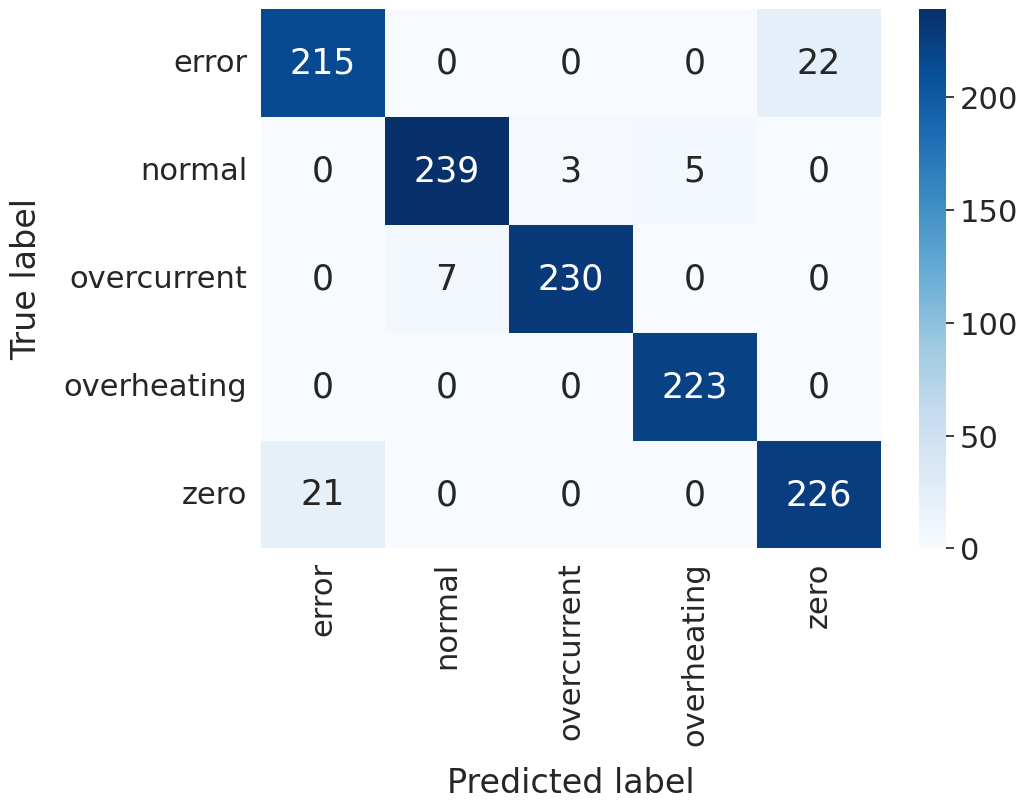

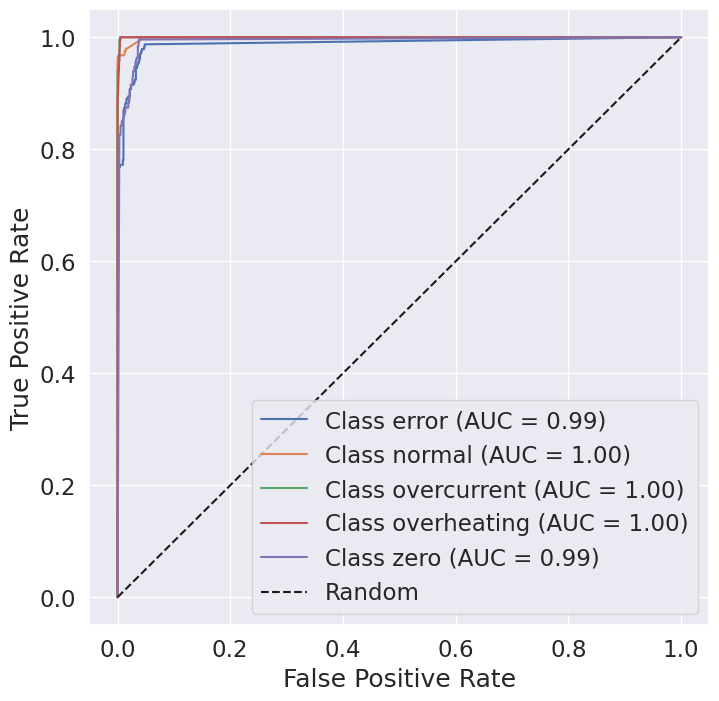

In [17]:
rf_val_cm = evaluate_and_print_results(y_pred=rf_y_pred_val, y_pred_proba=rf_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=rf_val_cm)
plot_auc_curve(y_pred_proba=rf_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

In [18]:
rf_y_pred = rf_fft.predict(X_test_RF)
rf_y_pred_proba = rf_fft.predict_proba(X_test_RF)

              precision    recall  f1-score   support

       error       0.93      0.92      0.93       445
      normal       0.95      0.98      0.96       419
 overcurrent       0.99      0.95      0.97       454
 overheating       0.99      0.98      0.99       411
        zero       0.92      0.94      0.93       431

    accuracy                           0.96      2160
   macro avg       0.96      0.96      0.96      2160
weighted avg       0.96      0.96      0.96      2160


Custom reports
Precision: 0.9556342234517976
Recall: 0.9557007658499668
Accuracy: 0.9550925925925926
F1-Score (Macro): 0.9555406861721194
Macro-average AUC (SVM): 0.996538312244898


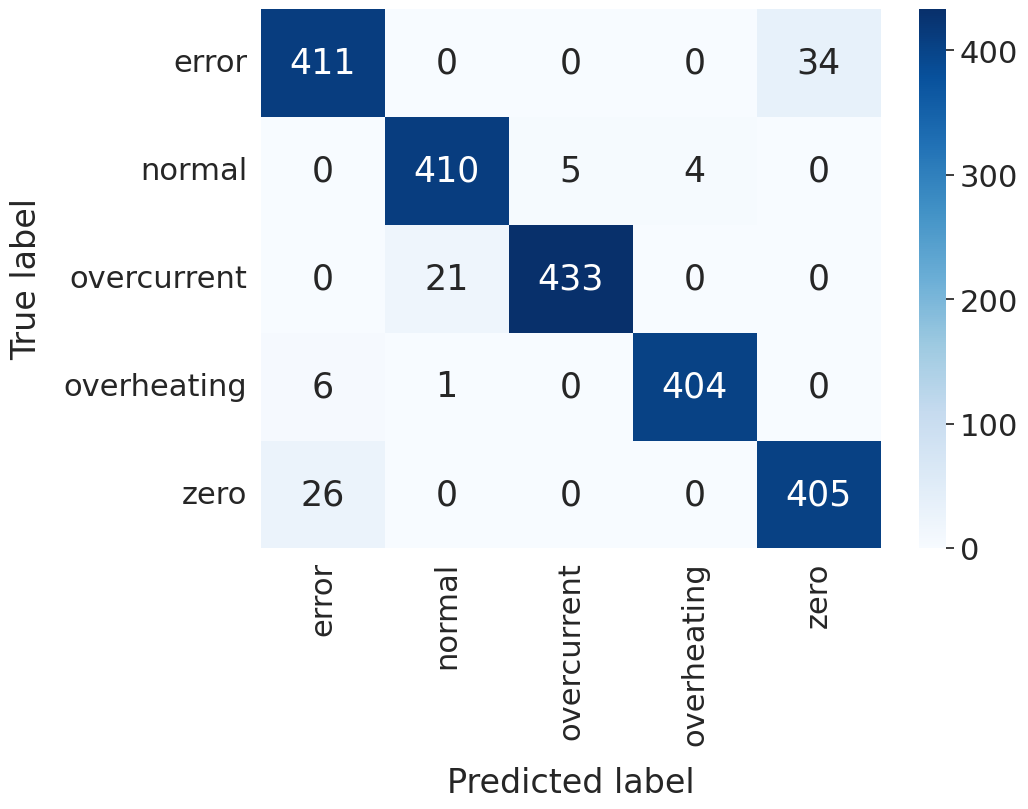

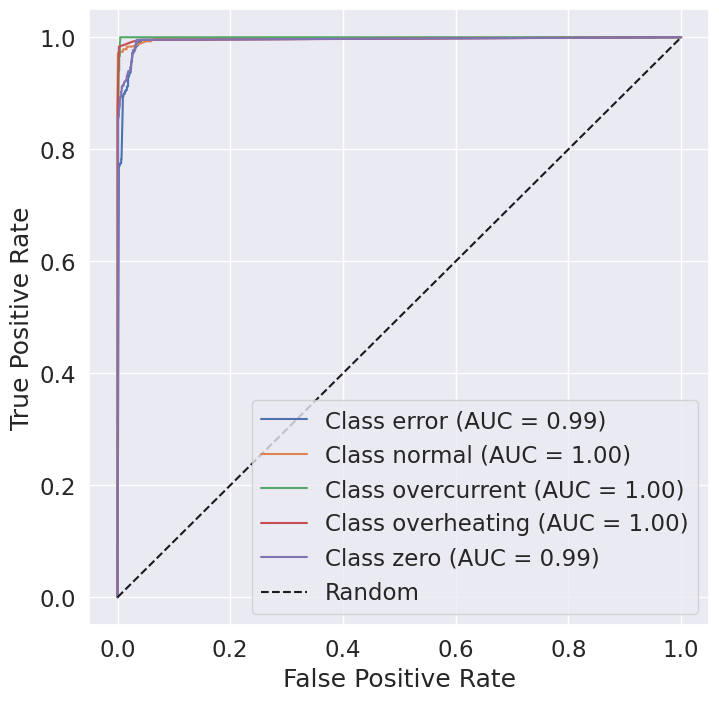

In [19]:
rf_cm = evaluate_and_print_results(y_pred=rf_y_pred, y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=rf_cm)
plot_auc_curve(y_pred_proba=rf_y_pred_proba, y_test=y_test, label_encoder=label_encoder)

## XgBoost

### Xây dựng mô hình

In [20]:
from xgboost import XGBClassifier
xgboost_fft = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
xgboost_fft.fit(X_train_XgBoost, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [21]:
xgb_y_pred_val = xgboost_fft.predict(X_validation_XgBoost)
xgb_y_pred_proba_val = xgboost_fft.predict_proba(X_validation_XgBoost)

              precision    recall  f1-score   support

       error       0.91      0.89      0.90       237
      normal       0.96      0.96      0.96       247
 overcurrent       0.98      0.98      0.98       237
 overheating       0.96      0.95      0.96       223
        zero       0.91      0.94      0.92       247

    accuracy                           0.94      1191
   macro avg       0.94      0.94      0.94      1191
weighted avg       0.94      0.94      0.94      1191


Custom reports
Precision: 0.9442602229170634
Recall: 0.9437654418728322
Accuracy: 0.943744752308984
F1-Score (Macro): 0.9439550342877567
Macro-average AUC (SVM): 0.9975186728664334


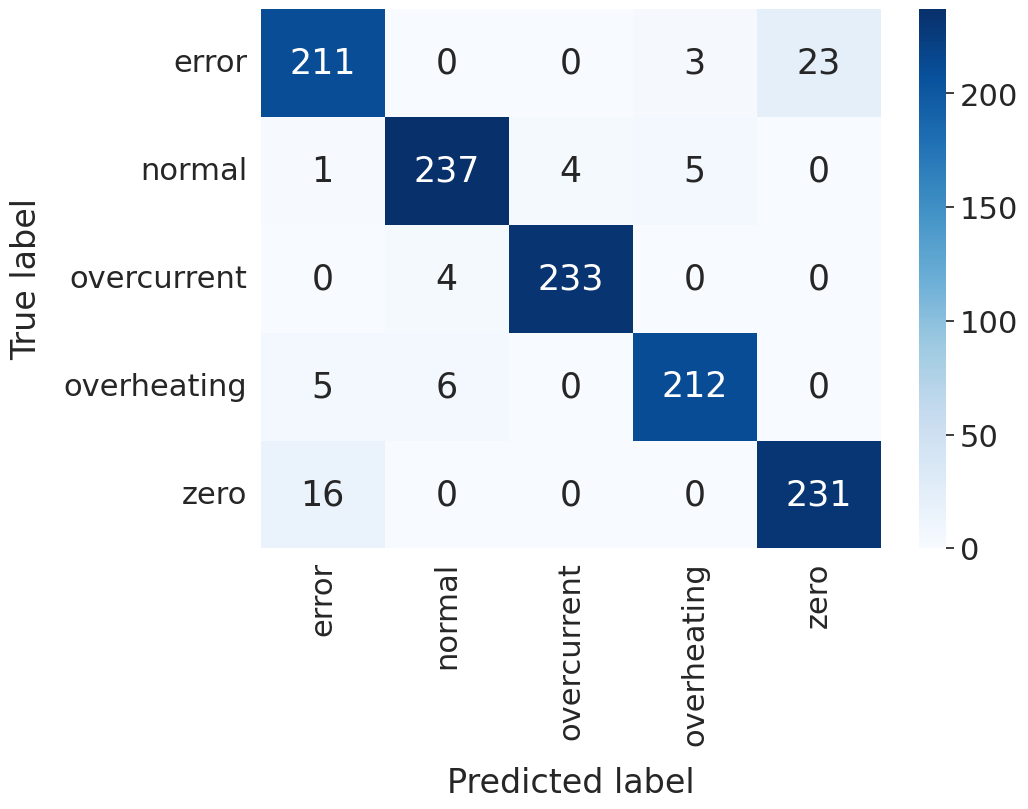

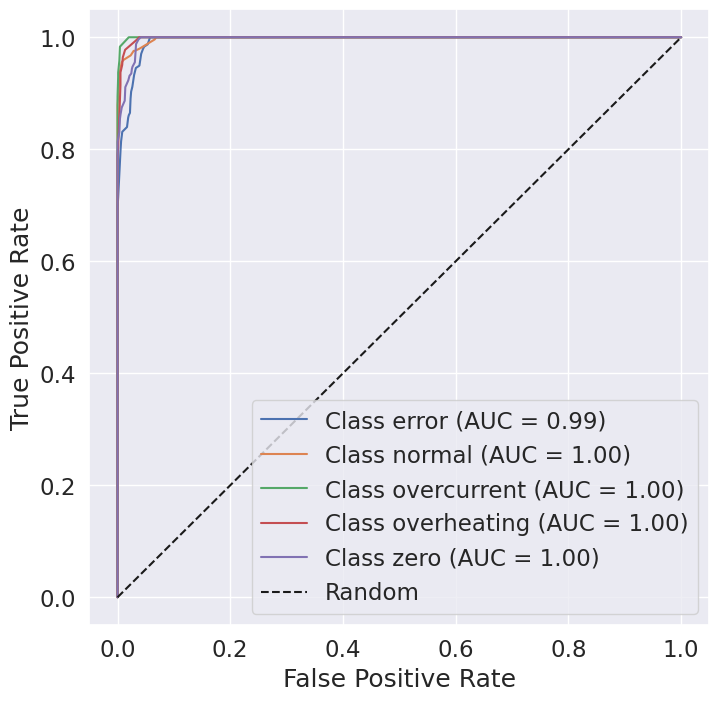

In [22]:
xgb_val_cm = evaluate_and_print_results(y_pred=xgb_y_pred_val, y_pred_proba=xgb_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=xgb_val_cm)
plot_auc_curve(y_pred_proba=xgb_y_pred_proba_val, y_test=y_validation, label_encoder=label_encoder)

In [23]:
xgb_y_pred = xgboost_fft.predict(X_test_XgBoost)
xgb_y_pred_proba = xgboost_fft.predict_proba(X_test_XgBoost)

              precision    recall  f1-score   support

       error       0.91      0.90      0.91       445
      normal       0.95      0.97      0.96       419
 overcurrent       0.98      0.96      0.97       454
 overheating       0.98      0.95      0.96       411
        zero       0.91      0.94      0.93       431

    accuracy                           0.95      2160
   macro avg       0.95      0.95      0.95      2160
weighted avg       0.95      0.95      0.95      2160


Custom reports
Precision: 0.9464606732366205
Recall: 0.9460738705393588
Accuracy: 0.9458333333333333
F1-Score (Macro): 0.9461467305895761
Macro-average AUC (SVM): 0.997801642668805


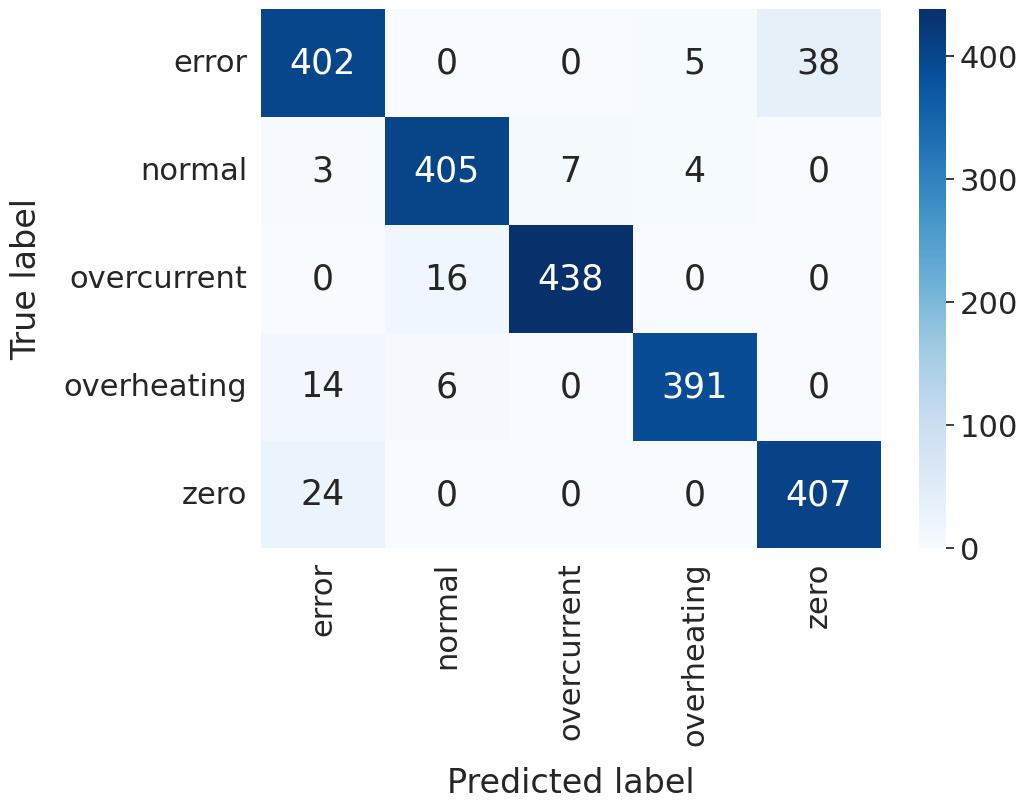

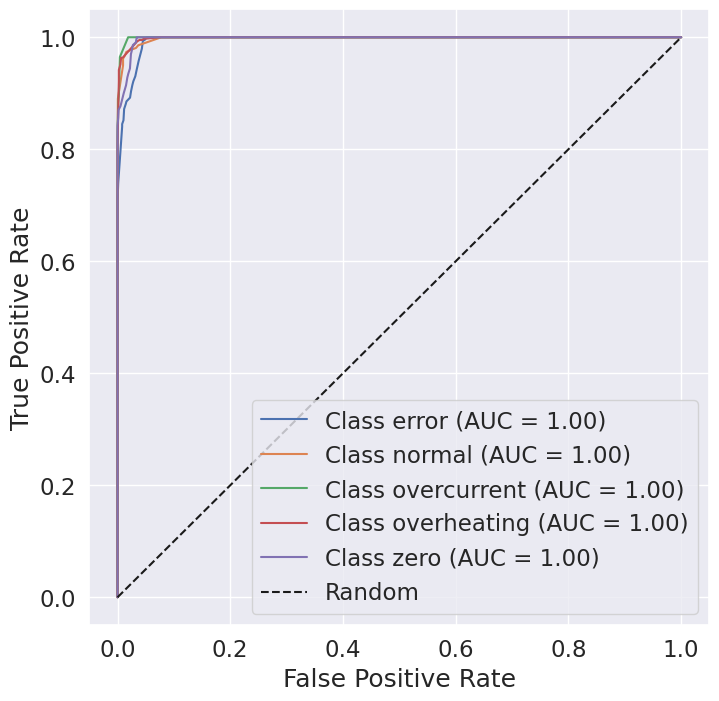

In [24]:
xgb_test_cm_test = evaluate_and_print_results(y_pred=xgb_y_pred, y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)
plot_conf_matrix(conf_matrix=xgb_test_cm_test)
plot_auc_curve(y_pred_proba=xgb_y_pred_proba, y_test=y_test, label_encoder=label_encoder)